# Regression methods
## Linear regression
## TS Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
import scipy as sc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Regression

In [2]:
from IPython.display import IFrame
IFrame(src="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#examples-using-sklearn-linear-model-linearregression", width=800, height=400)

In [3]:
from IPython.display import IFrame
IFrame(src="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge", width=800, height=400)

# Underfitting VS Overfitting

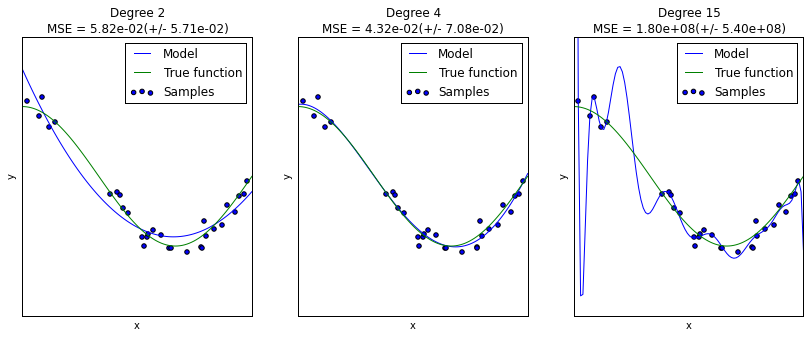

In [4]:
np.random.seed(0)

n_samples = 30
degrees = [2, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X) # ещё один способ определить функцию: с помощью lambda-функции

# Data Generation
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_validation.cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

# Time series forecasting

## Qualilty Functions

In [25]:
# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityR2(x,y):
    # R2 statistics
    # x - real values
    # y - forecasts
    mean_y = y.mean()
    return 1-qualitySSE(x,y)[0]/qualitySSE(x,[mean_y]*len(x))[0]
    

In [6]:
ts = pd.read_csv('consumption_train.csv', sep='\t', decimal=',', parse_dates={'Timestamp': pd.to_datetime(['Dates'],'dd.mm.yy hh:mm')}, index_col = 'Timestamp')
ts.head(24)

,EnergyCons,Dev,WeekDay
Timestamp,,,
2005-01-01 00:00:00,1290,-11,6
2005-01-01 01:00:00,1266,-12,6
2005-01-01 02:00:00,1273,-13,6
2005-01-01 03:00:00,1280,-14,6
2005-01-01 04:00:00,1293,-15,6
2005-01-01 05:00:00,1263,-16,6
2005-01-01 06:00:00,1279,-16,6
2005-01-01 07:00:00,1304,-16,6
2005-01-01 08:00:00,1330,-16,6


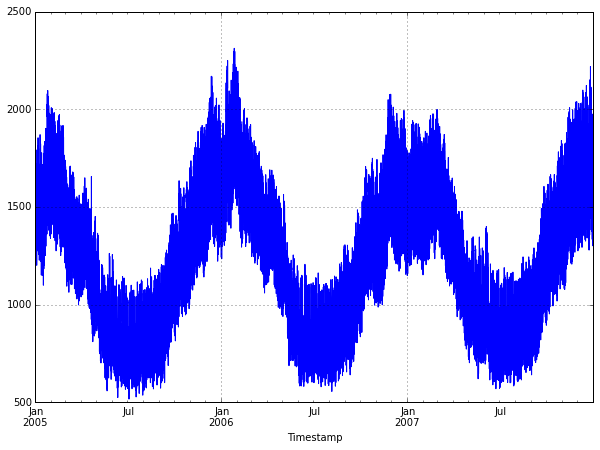

In [7]:
# Отобразим временные ряды
ts['EnergyCons'].plot(figsize(10,7))

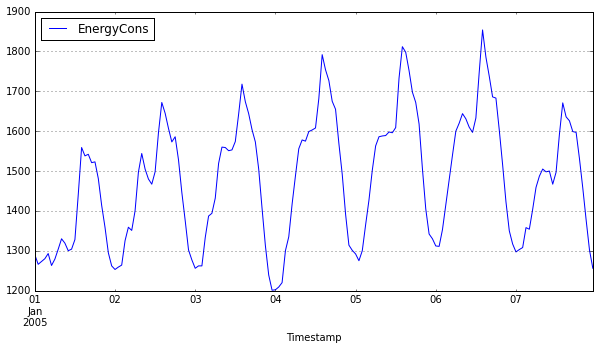

In [8]:
# the first week
ts.ix['2005-01-01 00:00:00':'2005-01-07 23:00:00', range(1)].plot(figsize(10,5))

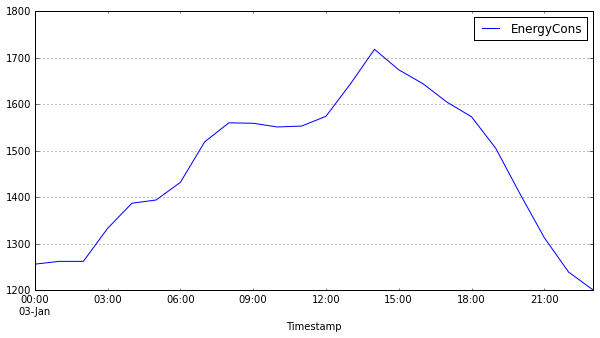

In [9]:
# the first day
ts.ix['2005-01-03 00:00:00':'2005-01-03 23:00:00', range(1)].plot(figsize(10,5))

## Autoregression

In [10]:
sc.linalg.hankel([1,2,3,4], [4,7,7,8,9])

array([[1, 2, 3, 4, 7],
       [2, 3, 4, 7, 7],
       [3, 4, 7, 7, 8],
       [4, 7, 7, 8, 9]])

In [11]:
def get_autoregrmatrix(x,h,K):
    L = len(x)
    X = sc.linalg.hankel(x[:L-h-K+1], x[-K:])
    y = x[K+h-1:]
    return X,y

### Прогноз следующий час (h=1) с окном истории - одна неделя (K=168)

In [12]:
K=168
h = 1 # delay

x_train = ts['EnergyCons'].ix['2005-01-01 00:00:00':'2006-01-01 00:00:00']
x_test = ts['EnergyCons'].ix['2006-01-01 00:00:00':'2006-01-30 00:00:00']

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)

# frc_ts['EnergyCons'] = SimpleExponentialSmoothing(x, h, Params)

In [13]:
print X_train.shape
print y_train.shape

(8593L, 168L)
(8593,)


In [14]:
# матрица объекты-признаки при авторегрессионном прогнозе
X_train

array([[1290, 1266, 1273, ..., 1377, 1302, 1256],
       [1266, 1273, 1280, ..., 1302, 1256, 1257],
       [1273, 1280, 1293, ..., 1256, 1257, 1267],
       ..., 
       [1332, 1293, 1225, ..., 1541, 1394, 1349],
       [1293, 1225, 1222, ..., 1394, 1349, 1312],
       [1225, 1222, 1278, ..., 1349, 1312, 1284]], dtype=int64)

In [15]:
# целевой вектор
y_train

Timestamp
2005-01-08 00:00:00    1257
2005-01-08 01:00:00    1267
2005-01-08 02:00:00    1274
2005-01-08 03:00:00    1339
2005-01-08 04:00:00    1376
2005-01-08 05:00:00    1400
2005-01-08 06:00:00    1439
2005-01-08 07:00:00    1504
2005-01-08 08:00:00    1557
2005-01-08 09:00:00    1518
2005-01-08 10:00:00    1500
2005-01-08 11:00:00    1501
2005-01-08 12:00:00    1546
2005-01-08 13:00:00    1645
2005-01-08 14:00:00    1718
...
2005-12-31 10:00:00    1648
2005-12-31 11:00:00    1622
2005-12-31 12:00:00    1662
2005-12-31 13:00:00    1755
2005-12-31 14:00:00    1841
2005-12-31 15:00:00    1851
2005-12-31 16:00:00    1822
2005-12-31 17:00:00    1773
2005-12-31 18:00:00    1714
2005-12-31 19:00:00    1645
2005-12-31 20:00:00    1541
2005-12-31 21:00:00    1394
2005-12-31 22:00:00    1349
2005-12-31 23:00:00    1312
2006-01-01 00:00:00    1284
Name: EnergyCons, Length: 8593

Train score: 0.996, Test score: 0.970


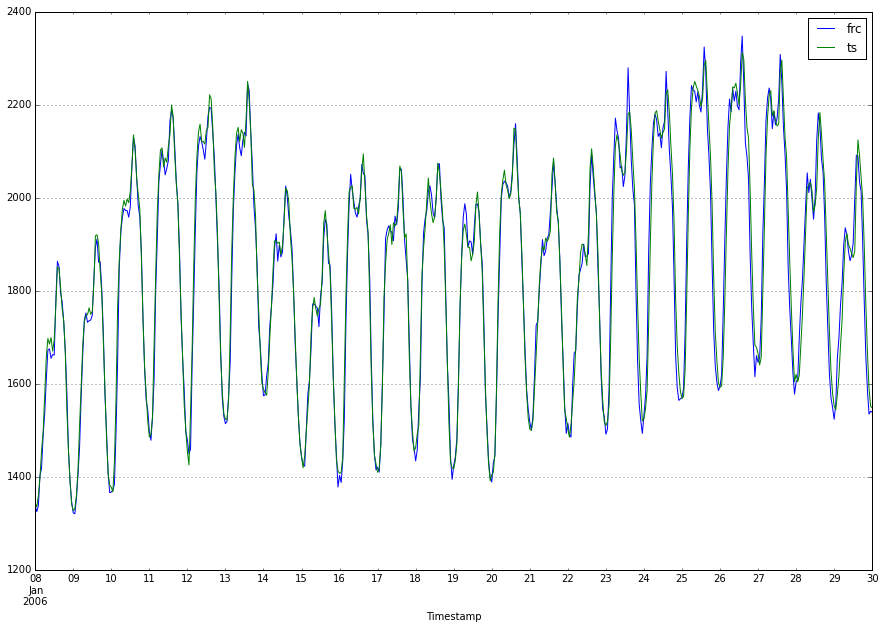

In [16]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize(15,10))

### Увеличим отсрочку проноза h=168

Train score: 0.934, Test score: 0.871


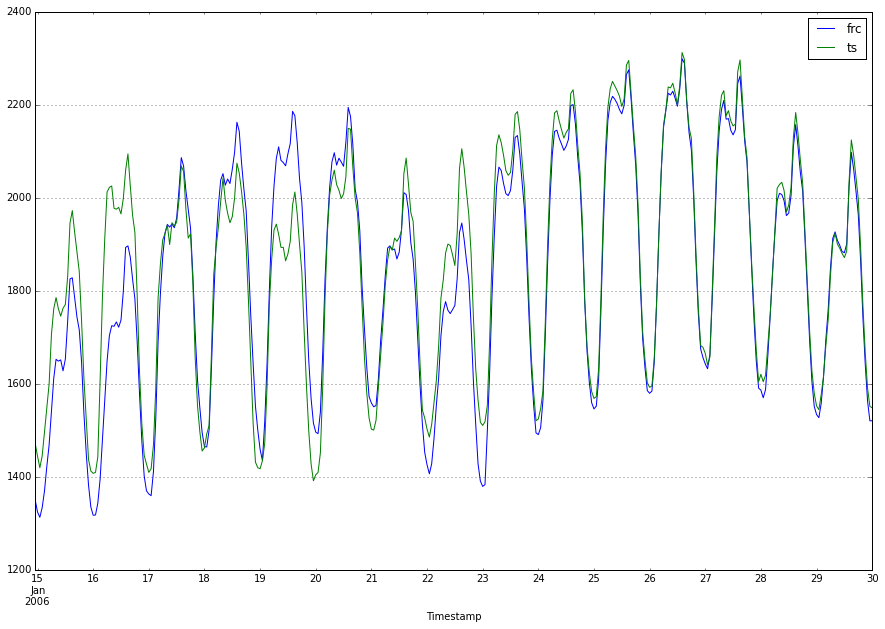

In [18]:
K=168
h = 168 # delay

x_train = ts['EnergyCons'].ix['2005-01-01 00:00:00':'2006-01-01 00:00:00']
x_test = ts['EnergyCons'].ix['2006-01-01 00:00:00':'2006-01-30 00:00:00']

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize(15,10))

## Exponential Smoothing Prediction

In [19]:
# Exponential Smoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter

def SimpleExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = y*alpha + (1-alpha)*x[cntr]
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

### Прогноз следующий час (h=1)

In [21]:
# Forecasting delay
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
#T = len(ts[ts.columns[0]])

In [22]:
# ES params
Params ={'alpha':0.9}
# forecast
x = ts['EnergyCons']
frc_ts['EnergyCons'] = SimpleExponentialSmoothing(x, h, Params)

Quality 0.767560753665


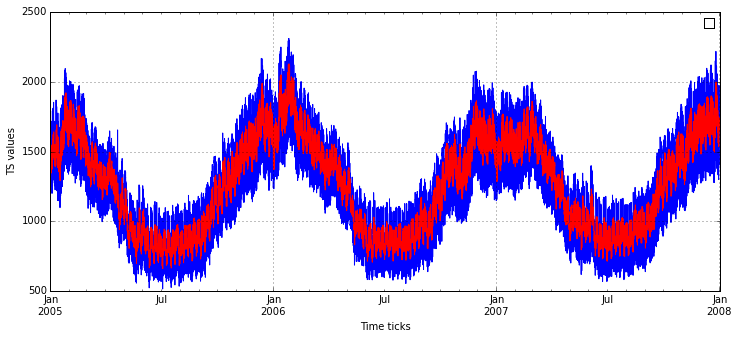

In [29]:
ts_num = 0 
ts[ts.columns[ts_num]].plot(style='b')
frc_ts[frc_ts.columns[ts_num]].plot(style='r', figsize=(12,5))
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend(['Time series'], ['ES Forecast'])
Qlt = qualityR2(ts['EnergyCons'], frc_ts['EnergyCons'])
print('Quality {}'.format(Qlt))

Quality 0.75081543519


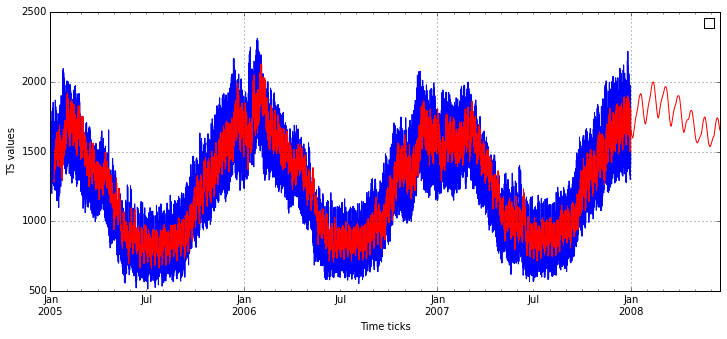

In [30]:
# Forecasting delay
h = 168
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
#T = len(ts[ts.columns[0]])
# ES params
Params ={'alpha':0.9}
# forecast
x = ts['EnergyCons']
frc_ts['EnergyCons'] = SimpleExponentialSmoothing(x, h, Params)
ts_num = 0 
ts[ts.columns[ts_num]].plot(style='b')
frc_ts[frc_ts.columns[ts_num]].plot(style='r', figsize=(12,5))
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend(['Time series'], ['ES Forecast'])
Qlt = qualityR2(ts['EnergyCons'], frc_ts['EnergyCons'])
print('Quality {}'.format(Qlt))

## ARMA

In [143]:
import statsmodels.api as sm

def myARMA(x, h, Params): # see statsmodels.ARMA
    
    # Параметры алгоритма
    p = Params['p']
    q = Params['q']
    
    start = ts.index[-1]+timedelta(1)
    end = ts.index[-1]+timedelta(h)
    rng = pd.date_range(start, end)
    frc_ts = pd.Series(index = x.index.append(rng))

    for t in range(len(x.index)): # итерационный процесс для честного прогнозирования
#         y = pd.Series(index = x.index[:t+1]
        y = x[:t+1]
        if not y.dropna().empty:
    #        return frc_ts
    #    else:
            try:
                arma_mod = sm.tsa.ARMA(y.dropna(), (p,q)).fit()
                frc_ts[t+h-1] = arma_mod.predict(start = y.index[-1]) # возвращаем последнее предсказанное значение
            except Exception:
                print("Can not fit model p=%d, q=%d at step t=%d!" % (p, q, t))
        
    # Извлекаем прогноз
    #start = notnan_x.index[0].to_datetime().strftime("%Y-%m-%d")
    #end = notnan_x.index[len(notnan_x)-1].to_datetime().strftime("%Y-%m-%d")
    return frc_ts.ffill()

In [ ]:
#Fit parameters
P = [1]
FRC_TS = dict()
h = 1
q = 0
ts_num = 4

for p_cntr in P:
    frc_ts = pd.DataFrame(index = ts.index.append(rng))
    Params ={'p':p_cntr, 'q': q}
    for ts_num in ts.columns:
        x = ts[ts_num]
        frc_ts[ts_num] = myARMA(x, h, Params)
    FRC_TS['ARMA p={0}, q={1}'.format(p_cntr,q)] = frc_ts

## SSA (Гусеница)

In [ ]:
def invhankel(x):
    x = x[:][::-1]
    rows = np.size(x,axis=0)
    cols = np.size(x,axis=1)
    l = list()
    for i in range(-rows+1,cols):
        l.append(np.mean(x.diagonal(i)))
    return np.array(l)

In [ ]:
def ssa1tick(x,K,r = -1):
# ssa1tick(x,K,r) one-tick SSA forecast
# returns - x1, Lambda
# after Golyandina N. Metod Gusenitsa-SSA: Prognoz vremennych ryadov. S-Pb. 2004. P. 23.
# 
# x [N,1] time series, one-dimensional
# K [int scalar] period
# r [int scalar] rank of Hankel matrix 
#
# Example
# x = [1 2 3 2 1 2 3 2 1 2 3]';
# x = [0 1 2 2 1 0 0 1 2 2 1 0 0 1 2]';
# x1 = ssa1tick(x,4);
# t = 1:length(x)+1;
# plot(t',[x1 [x;NaN]]); hold on
# plot(t',[x1 [x;NaN]], '.'); hold off
# axis tight
    N = len(x)
    L = N-K+1
    if L == N or L <= 1: 
        print 'not correct parametrs of hankel matrix'
        return np.array([0]),0
    X = sc.linalg.hankel(x,x[-K:]);
    #SVD 
    # U-columns are eigenvectors of XX', since
    U,Lambda,V = np.linalg.svd(X);      # XX' = ULV' * VLU' = UL2U => XX'U = UL2
    #idxr = find(diag(Lambda)>=Wmin);
    r1 = np.sum(np.array((Lambda>0),dtype = int))     # diag elements always decrease
    if r == -1 or r>r1:
        r=r1;# align the number of the eigenvectors

    X1 = np.dot(np.dot(U[:,0:r],np.diag(Lambda[0:r])), V[:,0:r].transpose()) # reconstruct the hankel matrix
    x1 = invhankel(X1);      # convert to the time series


    #Gram-Shmidt Orthogonalization
    # [U, R] = qr(X);
    # if nargin == 2, r=length(U(:,1)); end
    # 
    # X1 = U(:,1:r) * R; # reconstruct the hankel matrix
    # x1 = hankelmatrix(X1);      # convert to the time series
    
    pi = np.array([U[-1,0:r]])            # get the last component of the eigenvectors
    Up = U[0:-1,0:r]        # get the firt L-1 components of the eigenvectors
    if (1-np.sum(np.dot(pi,pi.transpose()))) == 0:
        g = 0
    else:
        R = 1/(1-np.sum(np.dot(pi,pi.transpose()))) * np.dot(Up,pi.transpose()) # compute the recursive ts coeffiftients
        g = np.dot(R.transpose(),x1[-np.size(R):])     # forecast os the weighted sum of the reconstructed ts
        #g = R'*x(end-L+2:end);     # try this (the raw ts)
    
    x1 = np.append(x1,np.array(g));                # append the forecast to the reconstructed ts
    return x1,np.diag(Lambda)

In [ ]:
def ssaMtick(x,M,K,r = -1):
    if r == -1:
        for m in range(1,M+1):
            print 1,'ForcastSSA for day',m,'th of ',M
            x, Lambda = ssa1tick(x[:m],K);
    else:
        for m in range(1,M+1):
            x, Lambda = ssa1tick(x[:m],K,r)
    return x